# Определение возраста покупателей

**Цель проекта**: построить модель для определения приблизительного возраста людей по фотографии.

**Шаги проекта**:

- откроим и изучим данные;
- построим график распределения возраста в выборке,
- изучим как устроен датасет,
- обучим модель,
- проанализируем результаты обучения модели

## Исследовательский анализ данных

### Откроем и изучим данные

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image
import numpy as np
import random

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
data.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Максимальный возраст в базе - 100 лет, минимальный - 1 год. Средний возраст составляет 31 год, что практически равно медиане - 29 лет.

### Построим график распределения возраста в выборке

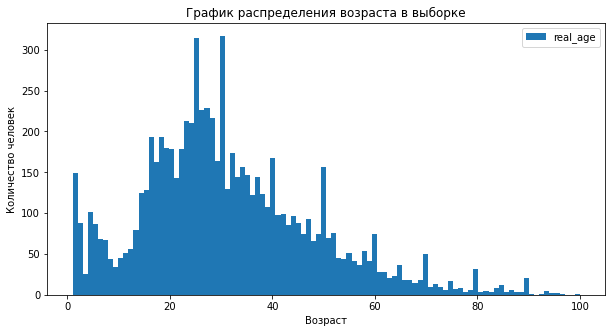

In [7]:
data.plot(kind = 'hist', legend = True, alpha = 1, bins = 100, figsize=(10, 5))
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество человек')
plt.show()

Таким образом, данные распределены неравномерно - больше всего людей на фото соответсвуют возрасту от 20 до 40 лет.

### Изучим как устроен датасет

Извлечем данные из папки 

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(256, 256),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Всего в папке 7591 изображений одного класса.

Напечатаем изображение

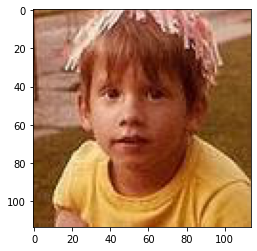

In [9]:
image = Image.open('/datasets/faces/final_files/000000.jpg')
array = np.array(image)
plt.imshow(array);


Напечатаем 15 изображений и посмотрим, как устроен датасет

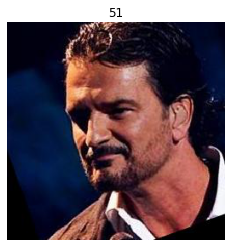

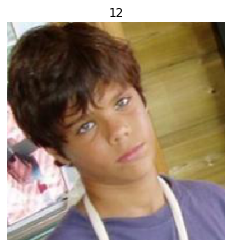

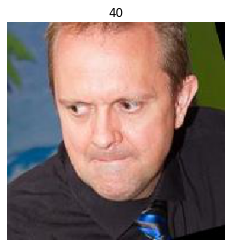

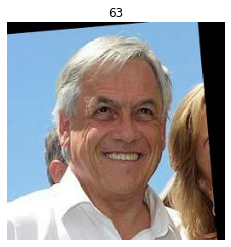

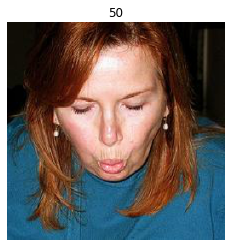

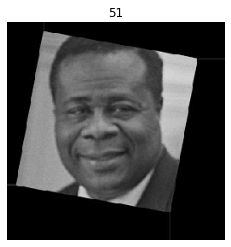

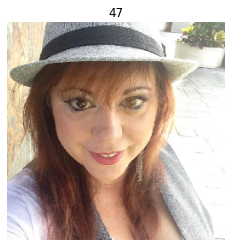

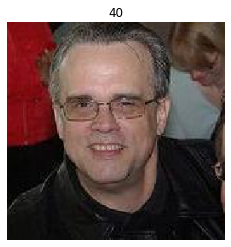

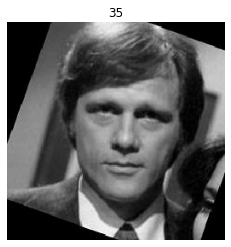

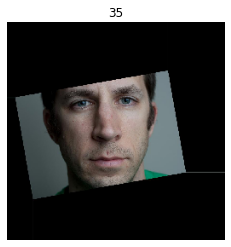

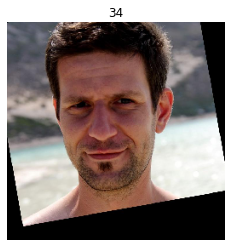

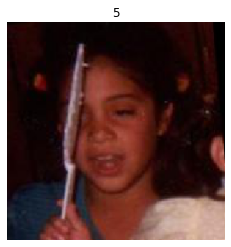

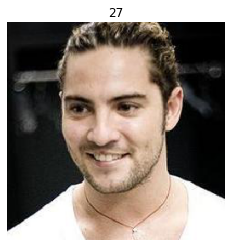

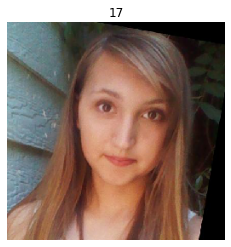

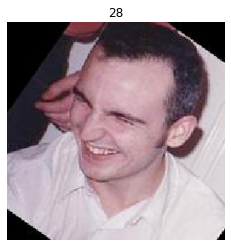

In [13]:
x,y = data_generator.next()
for i in range(0,15):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis('off')
    plt.show()

**Выводы** Изучив данные, можем отметить следующее:
- максимальный возраст в базе - 100 лет, минимальный - 1 год. Средний возраст составляет 31 год, что практически равно медиане - 29 лет;
-  данные распределены неравномерно - больше всего людей на фото соответсвуют возрасту от 20 до 40 лет;
- изображения в датасете - цветные и чернобелые; в профиль, полупрофиль, анфас; на некоторых фото лицо видно не полностью; взляд не всегда направлен в объектив.

Фотографии достаточно разнообразны, что поможет модели не переобучиться и показывать неплохой результат в определнии возраста. С другой строны, данных для категории менее 18 лет немного, что потребует применения дополнительных инстументов для отладки модели.

## Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50



def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                        dataframe=pd.read_csv(path + 'labels.csv'), 
                                        directory=path + 'final_files/', 
                                        x_col='file_name', 
                                        y_col='real_age', 
                                        target_size=(256,256),
                                        batch_size=16,
                                        class_mode='raw',
                                        subset='training',
                                        seed=12345)

    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
                                        dataframe=pd.read_csv(path + 'labels.csv'), 
                                        directory=path + 'final_files/', 
                                        x_col='file_name', 
                                        y_col='real_age', 
                                        target_size=(256,256),
                                        batch_size=16,
                                        class_mode='raw',
                                        subset='validation',
                                        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30,
               steps_per_epoch=None, validation_steps=None):
    

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/30
356/356 - 55s - loss: 197.6140 - mae: 10.2316 - val_loss: 561.0987 - val_mae: 18.4164
Epoch 2/30
356/356 - 47s - loss: 83.8158 - mae: 6.9529 - val_loss: 140.1695 - val_mae: 9.3884
Epoch 3/30
356/356 - 46s - loss: 60.7913 - mae: 5.9232 - val_loss: 76.1000 - val_mae: 6.6635
Epoch 4/30
356/356 - 47s - loss: 42.8445 - mae: 5.0389 - val_loss: 70.8561 - val_mae: 6.2372
Epoch 5/30
356/356 - 46s - loss: 32.6032 - mae: 4.3642 - val_loss: 84.4971 - val_mae: 6.9016
Epoch 6/30
356/356 - 47s - loss: 25.7142 - mae: 3.9309 - val_loss: 66.1642 - val_mae: 6.0762
Epoch 7/30
356/356 - 46s - loss: 21.3368 - mae: 3.5523 - val_loss: 65.2481 - val_mae: 5.9654
Epoch 8/30
356/356 - 46s - loss: 18.3652 - mae: 3.2621 - val_loss: 71.5760 - val_mae: 6.4859
Epoch 9/30
356/356 - 47s - loss: 16.2818 - mae: 3.0868 - val_loss: 72.4624 - val_mae: 6.6776
Epoch 10/30
356/356 - 46s - loss: 14.4453 - mae: 2.9300 - val_loss: 64.7468 - val_mae: 6.1886
Epoch 11/30
356/356 - 46s - loss: 14.0101 - mae: 2.8190 - val_loss: 66.6396 - val_mae: 6.0669
Epoch 12/30
356/356 - 47s - loss: 12.5714 - mae: 2.6676 - val_loss: 60.9800 - val_mae: 5.8823
Epoch 13/30
356/356 - 46s - loss: 12.1917 - mae: 2.6420 - val_loss: 70.4506 - val_mae: 6.2776
Epoch 14/30
356/356 - 47s - loss: 11.5653 - mae: 2.6212 - val_loss: 57.1763 - val_mae: 5.6566
Epoch 15/30
356/356 - 46s - loss: 11.3631 - mae: 2.5517 - val_loss: 64.4967 - val_mae: 6.0708
Epoch 16/30
356/356 - 43s - loss: 10.6220 - mae: 2.4808 - val_loss: 60.3112 - val_mae: 5.8088
Epoch 17/30
356/356 - 45s - loss: 10.4265 - mae: 2.4665 - val_loss: 67.9798 - val_mae: 6.1619
Epoch 18/30
356/356 - 46s - loss: 9.9655 - mae: 2.3895 - val_loss: 70.1971 - val_mae: 6.3982
Epoch 19/30
356/356 - 47s - loss: 9.8317 - mae: 2.3637 - val_loss: 59.7226 - val_mae: 5.7084
Epoch 20/30
356/356 - 47s - loss: 9.1528 - mae: 2.2634 - val_loss: 59.6674 - val_mae: 5.7661
Epoch 21/30
356/356 - 48s - loss: 9.1553 - mae: 2.3067 - val_loss: 71.5561 - val_mae: 6.6061
Epoch 22/30
356/356 - 48s - loss: 8.7349 - mae: 2.2246 - val_loss: 71.9752 - val_mae: 6.3539
Epoch 23/30
356/356 - 44s - loss: 8.1812 - mae: 2.1667 - val_loss: 60.7244 - val_mae: 5.7938
Epoch 24/30
356/356 - 47s - loss: 7.7833 - mae: 2.1149 - val_loss: 65.6743 - val_mae: 5.9927
Epoch 25/30
356/356 - 48s - loss: 7.1243 - mae: 2.0152 - val_loss: 56.4049 - val_mae: 5.6226
Epoch 26/30
356/356 - 48s - loss: 6.3067 - mae: 1.9080 - val_loss: 60.2246 - val_mae: 5.8842
Epoch 27/30
356/356 - 43s - loss: 7.4131 - mae: 2.0484 - val_loss: 64.2665 - val_mae: 5.9463
Epoch 28/30
356/356 - 44s - loss: 6.9336 - mae: 2.0013 - val_loss: 64.3804 - val_mae: 5.8183
Epoch 29/30
356/356 - 46s - loss: 6.7076 - mae: 1.9625 - val_loss: 65.3264 - val_mae: 6.1219
Epoch 30/30
356/356 - 46s - loss: 6.4314 - mae: 1.9289 - val_loss: 56.5316 - val_mae: 5.5751
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 56.5316 - mae: 5.5751
Test MAE: 5.5751


```

## Анализ обученной модели

Для решения поставленой задачи мы работали с сетью ResNet50, предобученной на датасете ImageNet; данные разделили на обучающую и тестовую выборки, с отделением валидационной равной 25 процентам. Нами применена активация ReLu и функция потерь Mean Squared Error, использован алгоритм обучения Adam с шагом 0.0001 на 30 эпохах.

Лучший результат - MAE 5.57, таким образом, модель определяет возраст покупателя по фото с погрешностью чуть менее 6 лет, что является приемлемым результатом.